# Solve cartpole with REINFORCE

> By Jonas Busk ([jbusk@dtu.dk](mailto:jbusk@dtu.dk))

**2019 update:** Changes have been made to the display of environments due to the previous `viewer` being incompatible with newer versions of Gym.

**2022 update:** Rendering was disabled, and the notebook now uses the `colabgymrender` package to render a video.

In this part, we will create an agent that can learn to solve the [cartpole problem](https://gym.openai.com/envs/CartPole-v0/) from OpenAI Gym by applying a simple policy gradient method called REINFORCE.
In the cartpole problem, we need to balance a pole on a cart that moves along a track by applying left and right forces to the cart.

We will implement a probabilistic policy, that given a state of the environment, $s$, outputs a probability distribution over available actions, $a$:

$$
p_\theta(a|s)
$$

The policy is a neural network with parameters $\theta$ that can be trained with gradient descent.
When the set of available actions is discrete, we can use a network with softmax output do describe the distribution.
The core idea of training the policy network is quite simple: *we want to maximize the expected total reward by increasing the probability of good actions and decreasing the probability of bad actions*.

To achieve this, we apply the gradient of the expected discounted total reward (return):

$$
\begin{align}
\nabla_\theta \mathbb{E}[R|\theta] &= \nabla_\theta \int p_\theta(a|s) R({a}) \, da \\
&= \int \nabla_\theta p_\theta(a|s) R(a)  \, da \\
&= \int p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) R(a) \, da \\
&= \mathbb{E}[\nabla_\theta \log p_\theta(a|s) R(a)]
\end{align}
$$

by definition of expectation and using the identity

$$
\nabla_\theta p_\theta(a|s) = p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) \ .
$$

The expectation cannot be evaluated analytically, but we have an environment simulator that when supplied with our current policy $p_\theta(a|s)$ can return a sequence of *actions*, *states* and *rewards*. This allows us to replace the integral with a Monte Carlo average:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) R_t \ ,
$$

which is our final gradient estimator, also known as REINFORCE. In the Monte Carlo estimator we run the environment simulator for a predefined number of steps with actions chosen stochastically according to the current stochastic action network $p_\theta(a|s)$.

*Note: For simple reinforcement learning problems (like the one we will address in this exercise) there are simpler methods that work just fine. However, the Policy Gradient method (with some extensions) has been shown to also work well for complex problems with high dimensional inputs and many parameters, where simple methods become inadequate.*

## Policy gradient

In [1]:
#Install colabgymrender to display gym environments in Colab
#!pip install gym[classic_control] > /dev/null 2>&1
#!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
#!pip install colabgymrender > /dev/null 2>&1
#!pip install imageio==2.4.1 > /dev/null 2>&1

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
from gym import wrappers
from colabgymrender.recorder import Recorder

  from scipy.ndimage.filters import sobel



First we create the environment:

In [3]:
env = gym.make('CartPole-v0') # Create environment


  and should_run_async(code)

  logger.warn(

  deprecation(

  deprecation(



A state in this environment is four numbers describing the position and speed of the cart along with the angle and angular speed of the pole.

There are two available actions: push the cart *left* or *right* encoded as 0 and 1.

In [4]:
s = env.reset()
a = env.action_space.sample()
print('sample state:', s)
print('sample action:', a )

sample state: [ 0.03933847  0.01348769 -0.03811304  0.02947645]
sample action: 1


Let us see how the environment looks when we just take random actions. Note that the episode ends when the pole either 1) is more than 15 degrees from vertical, 2) more outside of the frame or 3) the pole is successfully balanced for some fixed duration.

In [5]:
env = gym.make('CartPole-v0') # Create environment
env = Recorder(env, "./video") # To display environment in Colab
env.reset() # Reset environment

# Run environment
while True:
    action = env.action_space.sample() # Get a random action
    _, _, done, _ = env.step(action) # Take a step
    if done: break # Break if environment is done

#env.close() # Close environment
#env.play()

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Taking random actions does not do a very good job at balancing the pole. Let us now apply the Policy Gradient method described above to solve this task!

Let's first define our network and helper functions.

In [6]:
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_inputs, n_hidden_1, n_hidden_2, n_hidden_3, n_outputs, learning_rate):
        super(PolicyNet, self).__init__()
        # network
        self.hidden_1 = nn.Linear(n_inputs, n_hidden_1)
        self.hidden_2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.hidden_3 = nn.Linear(n_hidden_2, n_hidden_3)
        self.out = nn.Linear(n_hidden_3, n_outputs)
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=1e-6)

    def forward(self, x):
        x = self.hidden_1(x)
        x = F.relu(x)
        x = self.hidden_2(x)
        x = F.relu(x)
        x = self.hidden_3(x)
        x = F.relu(x)
        x = self.out(x)
        return F.softmax(x, dim=1)

    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))

In [7]:
def compute_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

To start with, our policy will be a rather simple neural network with one hidden layer. We can retrieve the shape of the state space (input) and action space (output) from the environment.

In [8]:
n_inputs = env.observation_space.shape[0]
n_hidden_1 = 32
n_hidden_2 = 64
n_hidden_3 = 128
n_outputs = env.action_space.n

print('state shape:', n_inputs)
print('action shape:', n_outputs)

state shape: 4
action shape: 2


In [9]:
# training settings

num_episodes = 1000
rollout_limit = 500 # max rollout length
discount_factor = 1 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.001 # you know this by now
val_freq = 100 # validation frequency

# setup policy network

policy = PolicyNet(n_inputs, n_hidden_1, n_hidden_2, n_hidden_3, n_outputs, learning_rate)

# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        s = env.reset()
        for j in range(rollout_limit):
            # generate rollout by iteratively evaluating the current policy on the environment
            with torch.no_grad():
                a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                a = torch.multinomial(a_prob, num_samples=1).squeeze().numpy()
            s1, r, done, _ = env.step(a)
            rollout.append((s, a, r))
            s = s1
            if done: break
        # prepare batch
        rollout = np.array(rollout)
        states = np.vstack(rollout[:,0])
        actions = np.vstack(rollout[:,1])
        rewards = np.array(rollout[:,2], dtype=float)
        returns = compute_returns(rewards, discount_factor)
        # policy gradient update
        policy.optimizer.zero_grad()
        a_probs = policy(torch.from_numpy(states).float()).gather(1, torch.from_numpy(actions)).view(-1)
        loss = policy.loss(a_probs, torch.from_numpy(returns).float())
        loss.backward()
        policy.optimizer.step()
        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(10):
                s = env.reset()
                reward = 0
                for _ in range(rollout_limit):
                    with torch.no_grad():
                        a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                        a = a_prob.argmax().item()
                    s, r, done, _ = env.step(a)
                    reward += r
                    if done: break
                validation_rewards.append(reward)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

  rollout = np.array(rollout)



start training
 100. mean training reward:  26.05, mean validation reward:  22.40, mean loss:  9.2758
 200. mean training reward:  39.88, mean validation reward:  70.30, mean loss: 13.1510
 300. mean training reward:  95.53, mean validation reward: 200.00, mean loss: 25.8282
 400. mean training reward: 134.75, mean validation reward: 198.00, mean loss: 25.7514
 500. mean training reward: 188.19, mean validation reward: 200.00, mean loss: 32.5432
 600. mean training reward:  92.27, mean validation reward:  98.00, mean loss: 17.6009
 700. mean training reward: 169.49, mean validation reward: 200.00, mean loss: 25.8904
 800. mean training reward: 199.27, mean validation reward: 200.00, mean loss: 25.6740
done


  and should_run_async(code)



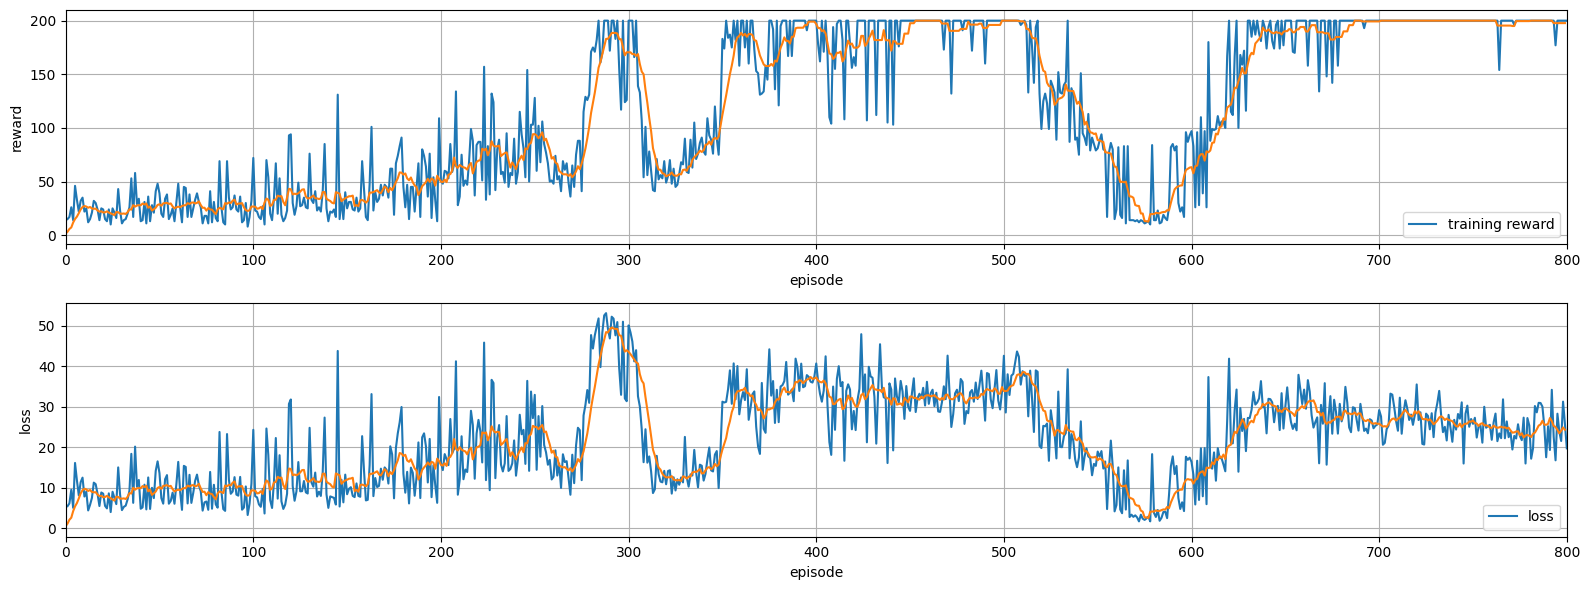

In [10]:
# plot results
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

Now let's review the solution!

In [11]:
env = Recorder(env, "./v1") # wrappers.Monitor(env, "./gym-results", force=True) # Create wrapper to display environment
s = env.reset()

for _ in range(500):
    a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
    s, r, done, _ = env.step(a)
    if done: break

#env.close()
#env.play()

  deprecation(



## Reducing variance

By default, this gradient estimator has high variance and therefore variance reduction becomes important to learn more complex tasks.
We can reduce variance by subtracting a baseline from the returns, which is unbiased in expectation:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) (R_t-b_t) \ ,
$$

where the baseline, $b_t$, is estimated by the return a timestep $t$ averaged over $V$ rollouts.

$$
b_t = \frac{1}{V} \sum_{v=1}^V R_t^{(v)} \ .
$$

## Exercises

Now it is your turn! Make sure you read and understand the code, then play around with it and try to make it learn better and faster.

Experiment with the:

* number of episodes
* discount factor
* learning rate
* network layers


### Exercise 1

*Describe any changes you made to the code and why you think they improve the agent. Are you able to get solutions consistently?*

**Answer:**

> *Added 2 additional hidden layers with doubling neurons. Also added weight decay but did not have a significant effect. The discount factor affects the results a lot but performance seems to be the best when it is between 0.9 and 1. After finding a suitable architecture the learning rate was tuned to it. In the end the best result was: Number of episode = 800, discount factor = 1, learning rate = 1e-3 and 2 additional layers with doubling neurons.*

### Exercise 2

**Answer:** \\
Sequence =[0, 1, 1, 1, 0, 1, 1, 0, 0, 0]
* *What is the total reward?*
> Answer: The total reward will be the sum of the sequence of rewards, 5

* *What is the total future reward in each timestep?*

> $R_t = r_t + r_{t+1} + r_{t+2} + \dots + r_T = \sum_{k=0}^{T-t} r_{t+k}$

In [12]:
def calculate_discounted_rewards(rewards, gamma):
    discounted_rewards = []
    for t in range(len(rewards)):
        discounted_reward = sum(gamma**k * rewards[t + k] for k in range(len(rewards) - t))
        discounted_rewards.append(discounted_reward)
    return discounted_rewards

# Example usage:
rewards = [0, 1, 1, 1, 0, 1, 1, 0, 0, 0]  # Your rewards array
gamma = 1
all_discounted_rewards = calculate_discounted_rewards(rewards, gamma)
print(all_discounted_rewards)  # Output: [4.28771, 4.76412, 4.29347, 3.65941, 2.9549, 2.72767, 1.91963, 1.02181, 0.11309, 0.0]


[5, 5, 4, 3, 2, 2, 1, 0, 0, 0]


* *What is the discounted future reward in each timestep if $\gamma = 0.9$?*
> $R_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \dots + \gamma^{T} r_T = \sum_{k=0}^{T-t} \gamma^k r_{t+k} $

In [13]:
def calculate_discounted_rewards(rewards, gamma):
    discounted_rewards = []
    for t in range(len(rewards)):
        discounted_reward = sum(gamma**k * rewards[t + k] for k in range(len(rewards) - t))
        discounted_rewards.append(discounted_reward)
    return discounted_rewards

# Example usage:
rewards = [0, 1, 1, 1, 0, 1, 1, 0, 0, 0]  # Your rewards array
gamma = 0.9
all_discounted_rewards = calculate_discounted_rewards(rewards, gamma)
print(all_discounted_rewards)  # Output: [4.28771, 4.76412, 4.29347, 3.65941, 2.9549, 2.72767, 1.91963, 1.02181, 0.11309, 0.0]


[3.560931, 3.95659, 3.2851, 2.539, 1.71, 1.9, 1.0, 0.0, 0.0, 0.0]


### Exercise 3

*In the training output, you will sometimes observe the validation reward starts out lower than the training reward but as training progresses they cross over and the validation reward becomes higher than the training reward. How can you explain this behavior?*

**Answer:**

During training, we employ both exploration and exploitation strategies, which yield a lower reward compared to validation, where we utilize the action associated with the highest probability.

### Exercise 4

*How does the policy gradient method we have used address the exploration-exploitation dilemma?*

*Hint: See the introduction notebook about exploration-exploitation.*

**Answer:**

The policy gradient method addresses the exploration-exploitation dilemma via a sampling approach. Initially, it explores the action space by sampling actions based on the current policy, aiding in discovering rewarding actions. As training advances, the model learns from the environment, and the policy parameters are updated to favor more rewarding actions, naturally transitioning towards exploitation. Unlike methods employing a decaying ε-greedy strategy, this shift doesn't require an explicit mechanism. The policy gradually becomes more exploitative while retaining some exploration due to its stochastic nature, effectively balancing the exploration-exploitation trade-off over time.